In [1]:
import glob
import numpy as np
from typing import Dict, List
from ephysvibe.structures.neuron_data import NeuronData
from ephysvibe.structures.population_data import PopulationData
from ephysvibe.structures.results import Results
from ephysvibe.trials import firing_rate, select_trials
import pandas as pd
from joblib import Parallel, delayed
from tqdm import tqdm
from ephysvibe.stats import smetrics
import warnings
import matplotlib.pyplot as plt
import seaborn as sns
import os

In [2]:
def check_trials(x, cerotr, percentile):
    masknocero = np.full(x.shape[0], True)
    maskper = np.full(x.shape[0], True)
    if cerotr:
        masknocero = np.sum(x, axis=1) != 0
    if percentile:
        maskper = select_trials.select_trials_by_percentile(x, masknocero)
    mask = np.logical_and(masknocero, maskper)

    return mask

In [3]:
path="//envau_cifs.intlocal.univ-amu.fr/work/invibe/USERS/IBOS/data/Riesling/TSCM/OpenEphys/population/in_out_b1_b2/2025_01_03_12_05_07/pfc/population.h5"

In [4]:
popu = PopulationData.from_python_hdf5(path)

In [5]:
neu=popu.population[50]

## Neutral index

In [6]:
start_sample = 0
end_sample = 400
cerotr, percentile=True,True
samples = [11, 15, 51, 55, 0]

In [7]:
def compute_roc_neutral(sp_son, sample_id, idx_start, idx_end):
    fr_son = firing_rate.moving_average(data=sp_son, win=100, step=1)[
        :, idx_start:idx_end
    ]
    fr_samples = select_trials.get_sp_by_sample(fr_son, sample_id, samples)
    # check trials fr
    for isamp in fr_samples.keys():
        if ~np.all((np.isnan(fr_samples[isamp]))):
            masktr = check_trials(fr_samples[isamp], cerotr, percentile)
            fr_samples[isamp] = fr_samples[isamp][masktr]
    sample = np.concatenate(
        (fr_samples["11"], fr_samples["15"], fr_samples["51"], fr_samples["55"])
    )
    n0 = fr_samples["0"]
    if np.all(np.isnan(n0)): return np.nan
    # Check selectivity and latency
    _, neutral_score, neutral_p = smetrics.get_selectivity(
        sample, n0, win=75, scores=True,sacale=False
    )
    neutral_score = neutral_score-0.5
    sig_mask = neutral_p < 0.05
    if np.sum(sig_mask)==0:
        iscore = np.argmax(np.abs(neutral_score))
        roc_neutral = neutral_score[iscore]
    else:   # Not sure if not set it to zero directly or search the max in all the epoch
        # iscore = np.argmax(np.abs(neutral_score[sig_mask]))
        roc_neutral = 0
    return roc_neutral

In [8]:
rn = []
for inout in ["in", "out"]:
    mask = getattr(neu, "mask_son_" + inout)
    sp_son = getattr(neu, "sp_son_" + inout)
    time_before_son = getattr(neu, "time_before_son_" + inout)

    idx_start = time_before_son + start_sample
    idx_end = time_before_son + end_sample
    sample_id = neu.sample_id[mask]
    roc_neutral = compute_roc_neutral(sp_son, sample_id, idx_start, idx_end)
    print(roc_neutral)
    rn.append(roc_neutral)

0
0


In [9]:
roc_neutral

0

## Spatial index

In [10]:
def get_screen_pos_b1b2(pos_b1,pos_b2,poscode_b2):
    # get the screen position of sample in b1 in contralateral trials
    u_pos, u_count = np.unique(
        pos_b1, axis=0, return_counts=True
    )
    imax = np.argmax(u_count)
    x_pos_b1, y_pos_b1 = u_pos[imax][0][0], u_pos[imax][0][1]
    # Concatenate and get unique position and code during b2 trials
    pos_and_code = np.concatenate(
        [pos_b2[:, 0], poscode_b2.reshape(-1, 1)], axis=1
    )
    u_pos = np.unique(pos_and_code, axis=0)
    # Find the closest screen position to b1 in b2
    diff = abs(abs(u_pos[:, :2]) - abs(np.array([x_pos_b1, y_pos_b1])))
    idx = np.argmin(np.sum(diff, axis=1))
    x_pos_b2 = abs(u_pos[idx, 0]) * np.sign(x_pos_b1)
    y_pos_b2 = abs(u_pos[idx, 1]) * np.sign(y_pos_b1)
    idx_in = np.logical_and(u_pos[:, 0] == x_pos_b2, u_pos[:, 1] == y_pos_b2)
    code_in = int(u_pos[idx_in][0][2])
    idx_out = np.logical_and(u_pos[:, 0] == -x_pos_b2, u_pos[:, 1] == -y_pos_b2)
    code_out = int(u_pos[idx_out][0][2])
    return code_in, code_out

In [11]:
start_sample = 0
end_sample = 400
cerotr, percentile=True,True

In [12]:
nid = neu.get_neuron_id()
# Define masks
b1in_mask = getattr(neu, "mask_son_in")
b2_mask = getattr(neu, "mask_ton_")
sp = getattr(neu, "sp_ton_")

time_before_ton = getattr(neu, "time_before_ton_")

idx_start = time_before_ton + start_sample
idx_end = time_before_ton + end_sample

fr = firing_rate.moving_average(data=sp, win=100, step=1)

# check b2
if np.sum(b2_mask) == 0:
    print("no block 2 trials") #return results

pos_b1 = neu.position[b1in_mask]
pos_b2 = neu.position[b2_mask]
poscode_b2 = neu.pos_code[b2_mask]
code_in, code_out = get_screen_pos_b1b2(pos_b1,pos_b2,poscode_b2)
if ~np.all(neu.pos_code[b1in_mask]==neu.rf_loc[b1in_mask]):
    aux = code_in
    code_in = code_out
    code_out = aux

conv_pos = {}
conv_all, n_trials = [], []
rs = []
for code in [code_in, code_out]:
    code_mask = poscode_b2 == code
    fr_pos = fr[code_mask]
    
    if ~np.all((np.isnan(fr_pos))):
        masktr = check_trials(fr_pos, cerotr, percentile)
        if np.sum(masktr)<5:
            roc_spatial = np.nan
        else:
            fr_pos = fr_pos[masktr]
            bl = np.mean(fr_pos[:,50:150],axis=1).reshape(-1,1).repeat(fr_pos.shape[1],axis=1)
            
            _, neutral_score, neutral_p = smetrics.get_selectivity(
                fr_pos[:, idx_start:idx_end], bl, win=75, scores=True,sacale=False
            )
            neutral_score = neutral_score-0.5
            sig_mask = neutral_p < 0.05
            if np.sum(sig_mask)==0:
                iscore = np.argmax(np.abs(neutral_score))
                roc_spatial = neutral_score[iscore]
            else:   # Not sure if not set it to zero directly or search the max in all the epoch
                # iscore = np.argmax(np.abs(neutral_score[sig_mask]))
                roc_spatial = 0
        print(roc_spatial)
        rs.append(roc_spatial)

0.13
0


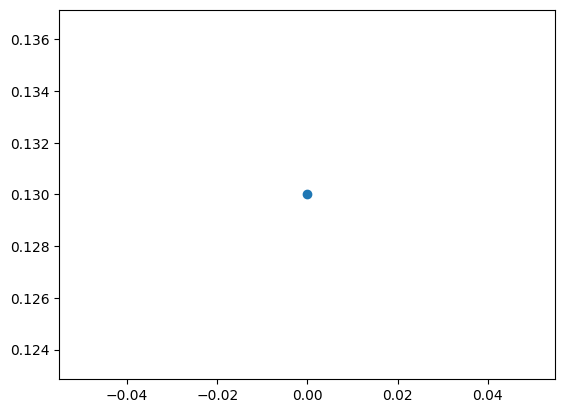

In [13]:
plt.scatter([rn[0]-rn[1]],[rs[0]-rs[1]])

In [14]:
from ephysvibe.dataviz import plot_raster

In [16]:
nid = neu.get_neuron_id() 
path=f'//envau_cifs.intlocal.univ-amu.fr/work/invibe/USERS/IBOS/data/Riesling/TSCM/OpenEphys/new_structure/session_struct/pfc/neurons/{nid}_neu.h5'
neu_n = NeuronData.from_python_hdf5(path)


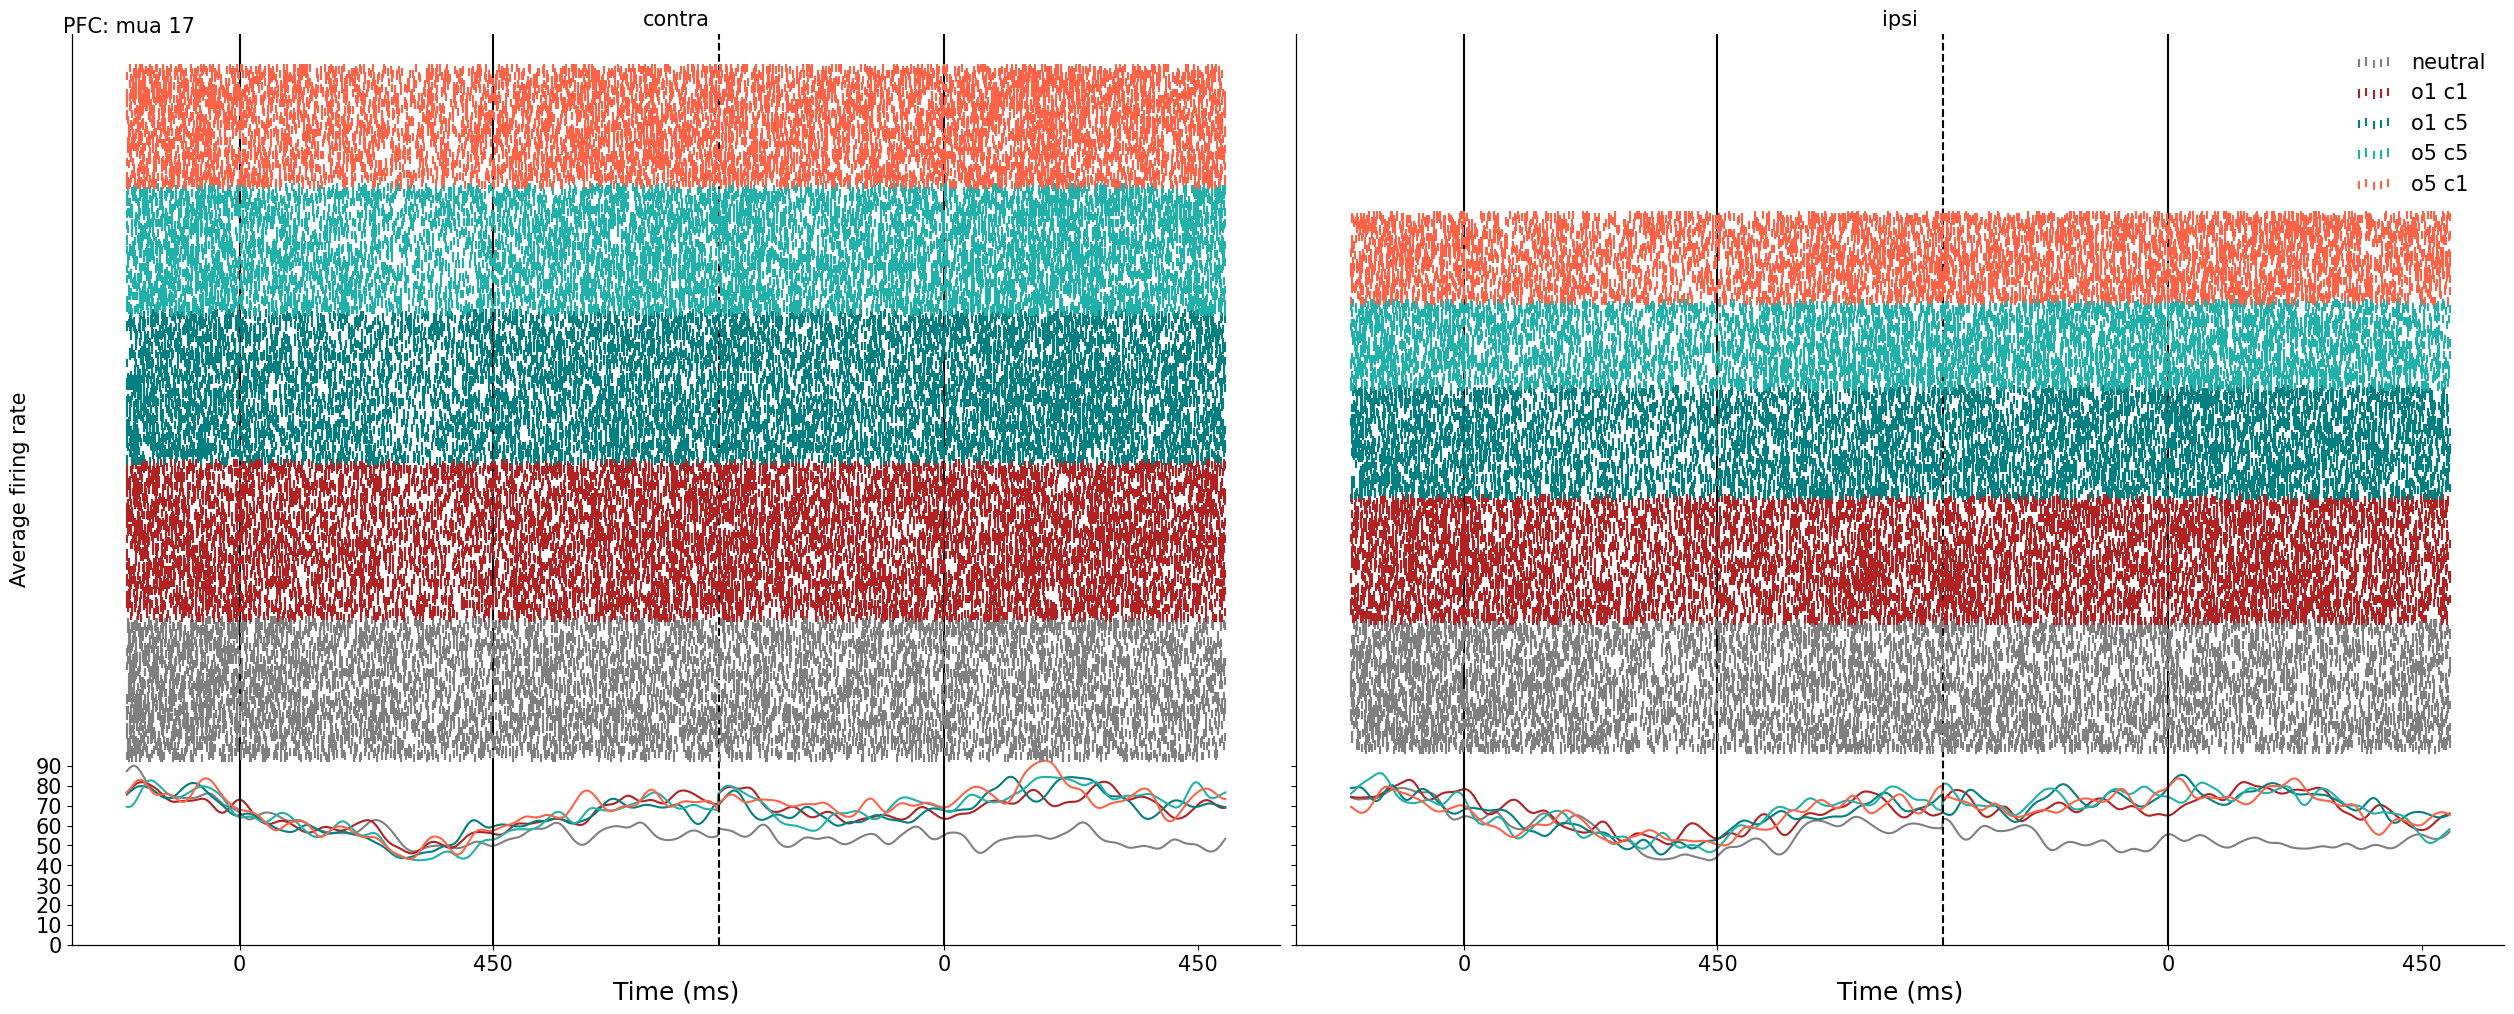

In [17]:
sp, conv = plot_raster.prepare_data_plotb1(neu_n,rf_stim_loc= ["contra", "ipsi"],cerotr=True,percentile=True)
fig=plot_raster.plot_sp_b1(neu_n,sp, conv)

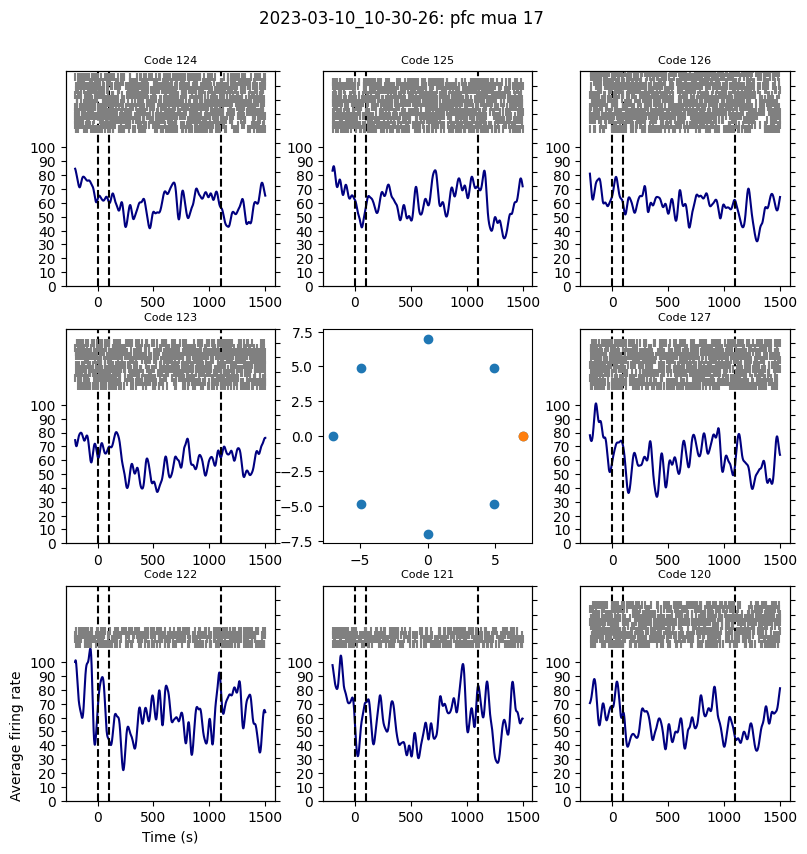

In [18]:
sp_pos, conv_pos, max_n_tr, conv_max = plot_raster.prepare_data_plotb2(neu_n)
fig = plot_raster.plot_sp_b2(neu_n,sp_pos, conv_pos, max_n_tr, conv_max, visual_rf=True,inout=1,bl_st=100, bl_end=200, tg_st=250, tg_end=350)